In [1]:
import anndata as ad
import pybedtools
from pybedtools import featurefuncs
import scanpy as sc
import os
import sys
import pandas as pd
import numpy as np
import muon
from muon import atac as ac
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.stats import gaussian_kde

In [2]:
sys.path.append(os.path.expanduser('~/atac_data/misc_scripts/'))
from map_peaks_to_genes import gtf_to_pybedtools
from map_peaks_to_genes import make_bed

In [3]:
!mkdir -p pbmc_10x #make new directory if doesn't exist

In [4]:
%cd pbmc_10x/

/home/danted/atac_data/pbmc_10x


Download the raw file, fragments file, and fragments file index

In [5]:
!wget -nc https://cf.10xgenomics.com/samples/cell-atac/2.1.0/10k_pbmc_ATACv2_nextgem_Chromium_Controller/10k_pbmc_ATACv2_nextgem_Chromium_Controller_filtered_peak_bc_matrix.h5 -O pbmc_10x/atac_v2_pbmc_10k_filtered_peak_bc_matrix.h5

pbmc_10x/atac_v2_pbmc_10k_filtered_peak_bc_matrix.h5: No such file or directory


In [6]:
!wget -nc https://cf.10xgenomics.com/samples/cell-atac/2.1.0/10k_pbmc_ATACv2_nextgem_Chromium_Controller/10k_pbmc_ATACv2_nextgem_Chromium_Controller_fragments.tsv.gz -O pbmc_10x/atac_v2_pbmc_10k_fragments.tsv.gz

pbmc_10x/atac_v2_pbmc_10k_fragments.tsv.gz: No such file or directory


In [7]:
!wget -nc https://cf.10xgenomics.com/samples/cell-atac/2.1.0/10k_pbmc_ATACv2_nextgem_Chromium_Controller/10k_pbmc_ATACv2_nextgem_Chromium_Controller_fragments.tsv.gz.tbi -O pbmc_10x/atac_v2_pbmc_10k_fragments.tsv.gz.tbi

pbmc_10x/atac_v2_pbmc_10k_fragments.tsv.gz.tbi: No such file or directory


Below is a custom script that takes as input an anndata object with peaks x cell matrix file generated via CellRanger and an appropriate gtf file to map peaks to transcript bodies following similar logic [here](10xgenomics.com/support/software/cell-ranger-atac/latest/analysis/peak-annotations)

I chose to use a custom script here for some fine tuning.

In [8]:
%run ~/atac_data/misc_scripts/map_peaks_to_genes.py --input_file atac_v2_pbmc_10k_filtered_peak_bc_matrix.h5  --gtf_file ~/atac_data/refdata-gex-GRCh38-2020-A/genes/genes.gtf

reading atac_v2_pbmc_10k_filtered_peak_bc_matrix.h5 into anndata object...
reading /home/danted/atac_data/refdata-gex-GRCh38-2020-A/genes/genes.gtf and subsetting by protein-coding transcripts...
annotating peaks to promoters...
annotating peaks to distal regions...
Identifying peaks that overlap with gene bodies...
annotating intergenic peaks...


Now we can use scanpy and muon to import the h5 file

In [9]:
atac = sc.read_10x_h5("atac_v2_pbmc_10k_filtered_peak_bc_matrix.h5", gex_only=False) #import the ATAC data
atac.var_names_make_unique() #make sure the variable names are unique

In [10]:
#removing peak scaffolds from the anndata
atac = atac[:, atac.var.loc[atac.var.index.str.contains("chr")].index].copy()

In [11]:
ac.tl.add_peak_annotation(atac, pd.read_csv("atac_peak_annotation.tsv", sep="\t", dtype=str)) #add peak annotations to the anndata

We're adding the peak annotation .tsv file we just created to the anndata object for storage, indexed by gene. Intergenic peaks which have NULL distance are annotated as 0 for storage purposes

See [here](https://pandas.pydata.org/pandas-docs/stable/user_guide/integer_na.html)

In [12]:
atac.uns['atac']['peak_annotation']

,peak,distance,peak_type
gene,,,
SAMD11,chr1:923353-924170,0,promoter
SAMD11,chr1:925410-926122,0,promoter
NOC2L,chr1:925410-926122,19440,distal
SAMD11,chr1:940016-940932,0,promoter
NOC2L,chr1:940016-940932,4630,distal
...,...,...,...
,chrY:21836169-21837044,0,intergenic
,chrY:26408700-26409528,0,intergenic
,chrY:26670683-26671627,0,intergenic


# scATAC-Seq QC

In [13]:
undetected_peaks = ((atac.X > 0).sum(0) == 0).sum()
print(f"Removing {undetected_peaks} undetected peaks")
atac = atac[: , ((atac.X > 0).sum(0) > 0)].copy()

Removing 0 undetected peaks


In [14]:
sc.pp.calculate_qc_metrics(atac, percent_top=None, log1p=False, inplace=True) #we can use scanpy to calculate peaks information

In [15]:
atac.obs.rename(columns={'n_genes_by_counts': 'n_fragments_by_counts'}, inplace=True) #change the name for intuitiveness

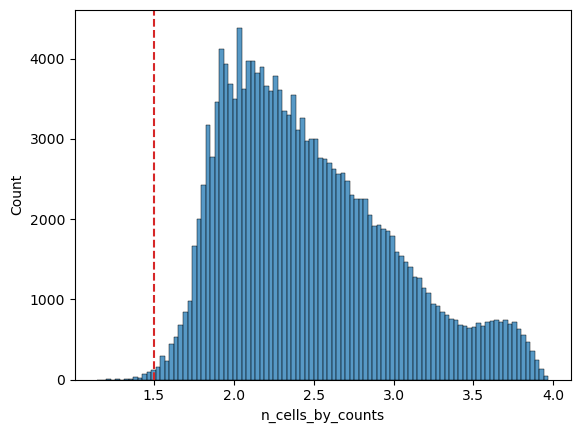

In [16]:
sns.histplot(np.log10(atac.var.n_cells_by_counts), bins=100)
plt.axvline(x=1.5, linestyle='--', c='tab:red')

Let's filter out peaks detected in less than ~30 cells based on the above graph

In [17]:
atac = atac[:, atac.var.n_cells_by_counts >= np.power(10,1.5)].copy() #filter out peaks detected in less than ~30 cells

### Next let's examine transcription start-sites (TSS) enrichment. Ideally, since the goal of ATAC-Seq is to capture open chromatin regions, we would expect there to be an enriched signal of peak counts at or around (+ or - 1kb) TSS.

Below, we first create a pybedtool object from a gtf file that we can interact with. We filter for all protein-coding transcripts. Here, we are using transcripts as opposed to genes simply because there can be multiple TSS for a given gene.

We then create a bedfile containing the coordinates of each TSS for each identified transcript.

This befile is then converted to a dataframe that muon can interact with to calculate the TSS enrichment score

In [18]:
tmp = gtf_to_pybedtools(gtf=os.path.expanduser("~/atac_data/refdata-gex-GRCh38-2020-A/genes/genes.gtf"), feature='transcript', saveas=True, ondisk=False)

In [19]:
tss = tmp.each(featurefuncs.five_prime, upstream=0, downstream=0).saveas().sort() #just the TSS

In [20]:
# Define the 'features' DataFrame with the specified columns if it's not already defined
features = pd.DataFrame(columns=['Chromosome', 'Start', 'End', 'gene_name'])

rows = []  # Initialize an empty list to collect rows

for i in tss:
    chrom, start, end, gene_name = i.chrom, i.start, i.end, i.name
    rows.append([chrom, start, end, gene_name])  # Append the row to the list

# Convert the list of rows into a DataFrame and append it to the existing 'features' DataFrame
tmp_df = pd.DataFrame(rows, columns=['Chromosome', 'Start', 'End', 'gene_name'])

tmp_df.set_index('gene_name', inplace=True, drop=False)

tmp_df.index.name = ''

In [21]:
#specify location of the fragments file that should have the same naming convention as the .tbi complementary file
ac.tl.locate_fragments(atac, fragments="atac_v2_pbmc_10k_fragments.tsv.gz")

In [ ]:
tss_enrichment = ac.tl.tss_enrichment(atac, extend_upstream=1000, extend_downstream=1000, features=tmp_df, n_tss=int(1e4), random_state=0)

Fetching Regions...: 100%|██████████| 10000/10000 [07:16<00:00, 22.92it/s]
/home/danted/miniforge3/envs/atac/lib/python3.9/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


Below we can nicely see that there is indeed good TSS Enrichment for high quality data

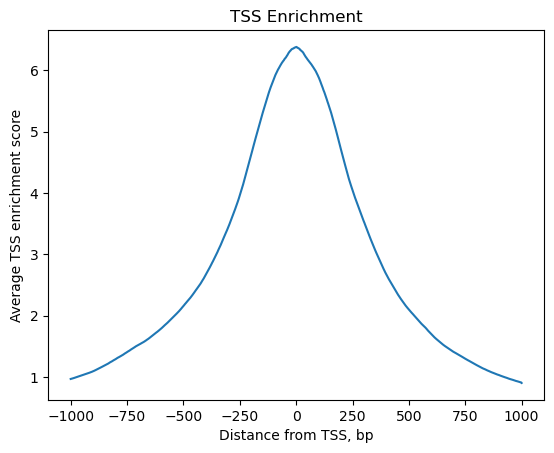

In [23]:
ac.pl.tss_enrichment(tss_enrichment)

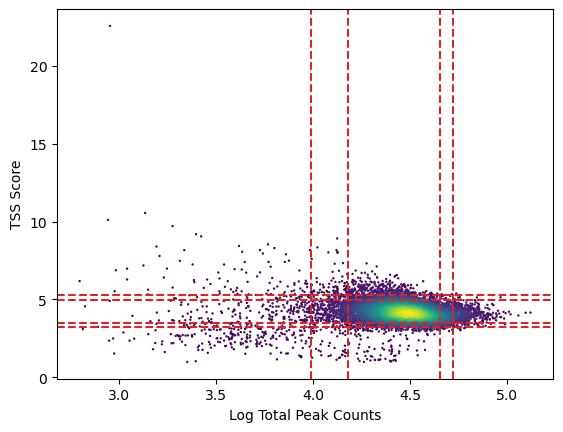

In [24]:
x = np.log10(atac.obs['total_counts'])
y = atac.obs['tss_score']
positions = np.vstack([x, y])

kde = gaussian_kde(positions)(positions)

plt.scatter(x, y, c=kde, cmap='viridis', s=0.5)
plt.axvline(np.quantile(x, 0.05), linestyle='--', c='tab:red')
plt.axvline(np.quantile(x, 0.1), linestyle='--', c='tab:red')
plt.axvline(np.quantile(x, 0.9), linestyle='--', c='tab:red')
plt.axvline(np.quantile(x, 0.95), linestyle='--', c='tab:red')

plt.axhline(np.quantile(y, 0.05), linestyle='--', c='tab:red')
plt.axhline(np.quantile(y, 0.1), linestyle='--', c='tab:red')
plt.axhline(np.quantile(y, 0.9), linestyle='--', c='tab:red')
plt.axhline(np.quantile(y, 0.95), linestyle='--', c='tab:red')

plt.xlabel("Log Total Peak Counts")
plt.ylabel("TSS Score")
plt.show()

Let's also look at the distribution of total counts of total reads per cell and the number of unique fragments per cell. This is akin to looking at the number of UMIs/cell and genes/cell in RNA-Seq data

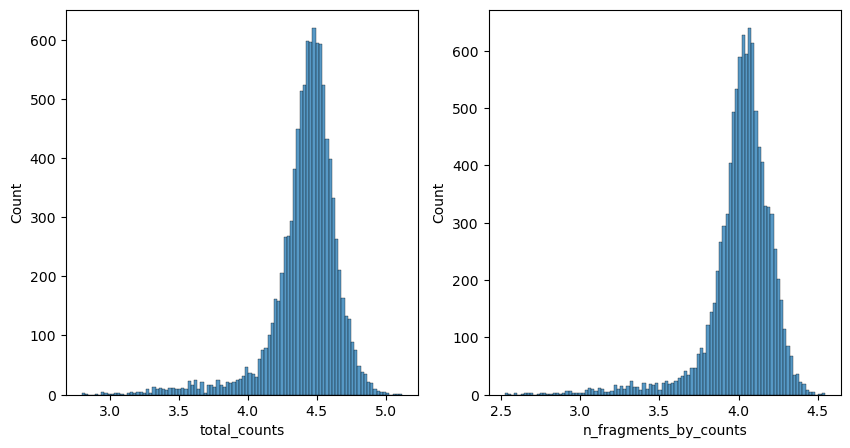

In [25]:
#log scale
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
sns.histplot(np.log10(atac.obs.total_counts), bins=100, ax=axs[0])
sns.histplot(np.log10(atac.obs.n_fragments_by_counts), bins=100, ax=axs[1])
plt.show()

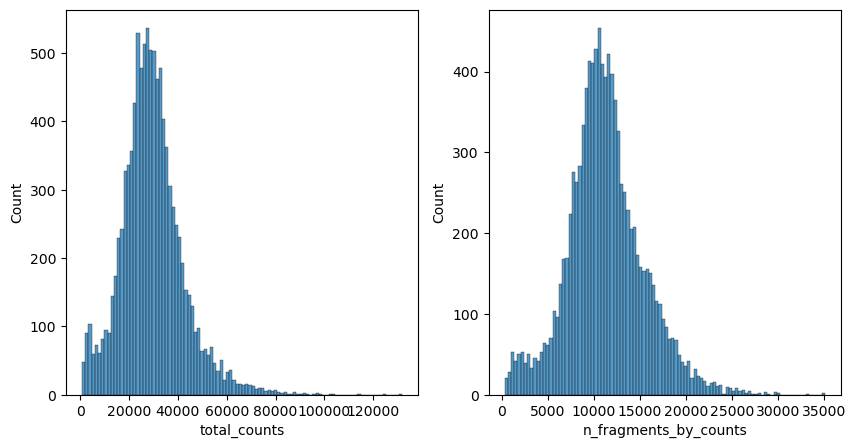

In [26]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
sns.histplot(atac.obs.total_counts, bins=100, ax=axs[0])
sns.histplot(atac.obs.n_fragments_by_counts, bins=100, ax=axs[1])
plt.show()

One useful metric to look at is the ratio of nucleosome signal based on fragment length. In ATAC-Seq, ideally, we would like to enrich for regions in the genome that are more accessible, or in other words, regions that occur between nucleosomes. We know that the typical periodicity of DNA wrapped around histones is 147 bps. As a result, we can examine the raio of total fragments with lengths less than 147 base pairs to those greater than 147 base pairs. The greater this ratio, the better quality for accessibility regions we can evaluate in each cell. Below we can plot this and see that cells with a nucleosome signal less than 4, there is enrichment of mononucleosomal signals signified by the large peak in the distribution at ~200 base pairs. 

In [27]:
ac.tl.nucleosome_signal(atac)

Reading Fragments: 100%|██████████| 102460000/102460000 [09:24<00:00, 181384.10it/s]


Fetching Regions...: 100%|██████████| 1/1 [00:17<00:00, 17.33s/it]


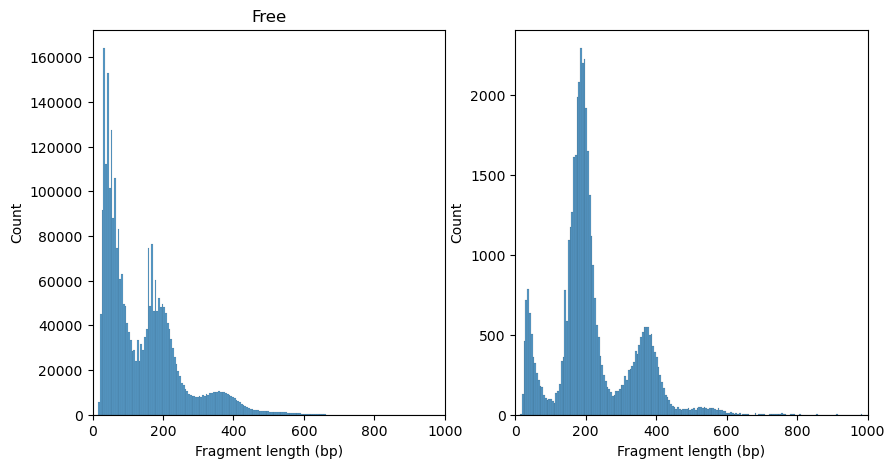

<Figure size 640x480 with 0 Axes>

In [28]:
atac.obs['NS'] = atac.obs['nucleosome_signal'].apply(lambda x: 'free' if x < 4 else 'mono')

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# First histogram
plt.sca(axs[0])  # Set the active axis to axs[0]
ac.pl.fragment_histogram(atac[atac.obs['NS'] == 'free'], region='chr1:1-20000000', show=False)
axs[0].set_title("Free")

# Second histogram
plt.sca(axs[1])  # Set the active axis to axs[1]
ac.pl.fragment_histogram(atac[atac.obs['NS'] == 'mono'], region='chr1:1-20000000', show=True)
axs[1].set_title("Mono")

plt.tight_layout()  # Adjust layout
plt.show()

Now we can filter the anndata object based on the criterion we have observed above

In [29]:
atac = atac[(np.log10(atac.obs.total_counts) > 4) & 
(np.log10(atac.obs.total_counts) < 5) &
(atac.obs.nucleosome_signal < 4) &
(atac.obs.tss_score > 3)].copy()

In [30]:
atac.write("pbmc_10x_atac_preprocess.h5ad")